# Embedded ML - Lab 2.2: TensorFlow Lite

In this lab you will learn the basics of TensorFlow Lite, a complement of TensorFlow that allows you to optimize and run models on constrained devices. It provides a much lighter runtime than TensorFlow but it only supports a subset of the tools available in full TensorFlow.

In this lab you might be given some helper functions but you are expected to write most of the code and be able to explain it at a high level of abstraction and also to modify any part of it.

### Learning outcomes


* Explain the basic concepts associated with TensorFlow Lite
* Develop applications following the basic TensorFlow Lite workflow
* Implement post-training quantization using TensorFlow Lite tools

#### Packages

In [ ]:
# TensorFlow y tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
import pathlib
# Librerias de ayuda
import numpy as np
import matplotlib.pyplot as plt

import os

## TensorFlow Lite workflow
After having built a TensorFlow model, you can convert it to the TensorFlow Lite representation. Then you can run it with the TensorFlow Lite interpreter on your development environment before exporting it and copying it to the target device.

To run the model with TensorFlow Lite you should load the model to the TensorFlow Lite interpreter, allocate the input/output tensors, pass the input data and finally run inference. Notice that TensorFlow Lite API calls are different from those of TensorFlow.

In this part of the assignment, you should create and train a simple model (e.g. a one-neuron network) with TensorFlow and then save it. Then follow the TensorFlow Lite workflow until you are able to run inference and validate the outputs.

In [ ]:
#### TENSORFLOW BASIC WORKFLOW

# Create the model
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
y = np.array([0, 1, 1, 0], dtype=np.float32)
model =  keras.Sequential()

model.add(layers.Input(shape=(2,)))
model.add(layers.Dense(4, activation = 'relu'))
model.add(layers.Dense(1))
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.1),
              loss='MAE',
              metrics=['accuracy'])

# Train the model
model.fit(x, y, epochs=200, verbose = 0)

# Save the model to a file
model.save('model_xor.keras')

In [ ]:
print(model.predict(x))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
[[0.00921456]
 [1.0213648 ]
 [1.0619187 ]
 [0.00921456]]


In [ ]:
#### TENSORFLOR LITE BASIC WORKFLOW
def tf_convert_to_tflite(input_model, tf_path_model):
  # Load model
  model = keras.models.load_model(input_model)
  # Convert model to TF Lite
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  tflite_model = converter.convert()
  # Save TF Lite model to a file
  tflite_model_file = pathlib.Path(tf_path_model)
  tflite_model_file.write_bytes(tflite_model)

In [ ]:
# Set up input/output tensors
#interpreter = tf.lite.Interpreter(model_content=tflite_model)
def tflite_interpreter(tf_lite_path):
  interpreter = tf.lite.Interpreter(model_path=tf_lite_path)
  interpreter.allocate_tensors()

  # Set input values
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  return interpreter, input_details, output_details
def tf_lite_inference(interpreter, input_details, output_details, data):
  input_dtype = input_details[0]['dtype']
  if input_dtype == np.uint8:
    # Handle uint8 quantization (as originally implemented)
    input_scale, input_zero_point = input_details[0]['quantization']
    to_predict = data / input_scale + input_zero_point
    to_predict = np.clip(to_predict, 0, 255).astype(np.uint8)
  elif input_dtype == np.int8:
    # int8 quantization
    input_scale, input_zero_point = input_details[0]['quantization']
    # Cast data to float32 first for scaling, then to int8
    to_predict = np.array(data, dtype=np.float32) / input_scale + input_zero_point
    to_predict = np.clip(to_predict, -128, 127).astype(np.int8) # int8 range is -128 to 127
  elif input_dtype == np.float16:
    to_predict = np.array(data, dtype=np.float16)
  else:
    # float32 input
    to_predict = np.array(data, dtype=np.float32)

  #to_predict = np.array(data, dtype=np.float32)
  interpreter.set_tensor(input_details[0]['index'], to_predict)
  # Run inference
  interpreter.invoke()
  # Get outputs
  tflite_results = interpreter.get_tensor(output_details[0]['index'])
  return tflite_results


In [ ]:
tf_convert_to_tflite('model_xor.keras', 'model_xor.tflite')
interpreter, input_details, output_details = tflite_interpreter('model_xor.tflite')
results = tf_lite_inference(interpreter,
                            input_details,
                            output_details,
                            data = [[1,0]])
print(results)

Saved artifact at '/tmp/tmpk2w_6644'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 2), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136419502524560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418558184720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418558184912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418557748304: TensorSpec(shape=(), dtype=tf.resource, name=None)
[[1.0619187]]


## Vision model with TensorFlow Lite

In this part of the assignment, you should import a small pre-trained model for a vision application that takes at most 1 MB. Then you should follow the TensorFlow Lite workflow until you are able to run inference and obtain the same results as with TensorFlow.

#### Preprocess

In [ ]:
def load_preprocess(num_train, IMG_SIZE = (96,96)):
  fashion_mnist = keras.datasets.fashion_mnist
  (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

  train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
  test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

  class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

  num_classes = len(class_names)

  #====================================
  # Acomodar dimensiones de los datos
  #====================================
  train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
  test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

  # Seleccionar una porción para Transfer
  num_test = int(num_train * 0.2)

  # Nuevo tamaño train
  train_images = train_images[:num_train]
  train_labels = train_labels[:num_train]
  # Nuevo tamaño test
  test_images = test_images[:num_test]
  test_labels = test_labels[:num_test]
  # =====================
  # Acomodar dimensiones para ajustar al modelo
  # ====================
  train_images = tf.image.resize(train_images, IMG_SIZE)
  test_images = tf.image.resize(test_images, IMG_SIZE)
  # ======================
  # Pasar a 3 Canales
  # ======================
  train_images = tf.repeat(train_images, 3, -1)
  test_images = tf.repeat(test_images, 3, -1)

  BATCH_SIZE = 32 # You can adjust this batch size

  # Create a dataset from your training data
  train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

  # Shuffle and batch the dataset
  train_dataset = train_dataset.shuffle(buffer_size=len(train_images)).batch(BATCH_SIZE)

  # Do the same for your test data (shuffling is less critical for testing)
  test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
  test_dataset = test_dataset.batch(BATCH_SIZE)

  return train_dataset, test_dataset, num_classes

### Run pretrained Model using MobileNetV1

In [ ]:
IMG_SIZE = (128,128)
train_dataset, test_dataset, num_classes = load_preprocess(2000, IMG_SIZE)

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
# build a new model adding a softmax layer
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNet(
    input_shape=IMG_SHAPE,
    alpha = 0.25,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = tf.keras.Sequential([
    rescale,
    base_model,
    layers.Flatten(),
    layers.Dense(num_classes, activation = 'softmax')
])

model.compile('adam',#optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
history = model.fit(
    train_dataset,
    epochs=10
)



29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
2108140/2108140 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.5800 - loss: 1.4317
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.8895 - loss: 0.3383
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.9290 - loss: 0.1977
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9547 - loss: 0.1258
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.9713 - loss: 0.0927
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9816 - loss: 0.0616
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9900 - loss: 0.0393
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.9952 - loss: 0.0303
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9990 - loss:

#### Test Orginal Model

In [ ]:
model.save('mobileNet_fashion.keras')

init_time = time.time()
loss, accuracy_original = model.evaluate(test_dataset)
time_original = (time.time() - init_time)/400
print(f'Time: {time_original}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.8401 - loss: 0.4809
Time: 0.0074730819463729855


### TF LITE

In [ ]:
tf_convert_to_tflite('mobileNet_fashion.keras', 'mobileNet_fashion.tflite')

Saved artifact at '/tmp/tmpa0cjjuzy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  136418409267024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418394588368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418394587216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418394588560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418394587408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418394587792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418394590672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418394591056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418394590864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418394587600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418394592

In [ ]:
# Model Size
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size*1e-6
size_original = get_file_size('mobileNet_fashion.keras')
size_tflite = get_file_size('mobileNet_fashion.tflite')
print(f'Tamaño modelo original: {get_file_size("mobileNet_fashion.keras")} MB')
print(f'Tamaño modelo TF Lite: {get_file_size("mobileNet_fashion.tflite")} MB')

Tamaño modelo original: 1.691082 MB
Tamaño modelo TF Lite: 1.022436 MB


In [ ]:
CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

unbatched_dataset = test_dataset.unbatch()

def evaluate_tflite_model(saved_tflite_model, unbatched_dataset):
  acc = 0
  N = 0
  for element in unbatched_dataset:
    N += 1
  init = time.time()
  interpreter, input_details, output_details = tflite_interpreter(saved_tflite_model)

  for image, label in unbatched_dataset.take(N):
    # Get the first image from the batch
    single_label = label.numpy()
    #print(image)
    image =  (tf.expand_dims(image, axis=0)).numpy()
    #print(image)
    results = tf_lite_inference(interpreter,
                                input_details,
                                output_details,
                                data=image)
    predicted = np.argmax(results)
    original = np.argmax(single_label)
    #print(f'Predicted: {CLASS_NAMES[predicted]} ')
    #print(f'Original: {CLASS_NAMES[original]} ')
    if predicted == original:
      #print('Correct')
      acc+=1
    # else:
    #   #print('Incorrect')
    # print('---------')

  print(results)
  print(type(results[0][0]))

  print(f'accuracy = {(acc/N)*100}%')
  end_time = (time.time()-init)/N
  print(f'Average time: {end_time}')
  return acc/N, end_time
acc_tflite, time_tflite = evaluate_tflite_model('mobileNet_fashion.tflite', unbatched_dataset)


[[5.2377613e-06 3.3072965e-07 9.9956149e-01 1.3675275e-06 2.8887416e-05
  3.0534396e-14 4.0267437e-04 9.9243620e-11 1.2783431e-07 2.6738920e-09]]
<class 'numpy.float32'>
accuracy = 87.5%
Average time: 0.001448293924331665


## Post-training quantization
Finally, in this part of the assignment you should activate quantization and convert the model again. Compare model size and accuracy of the compressed TensorFlow Lite model by using various configurations (investigate how) and against the uncompressed baseline.

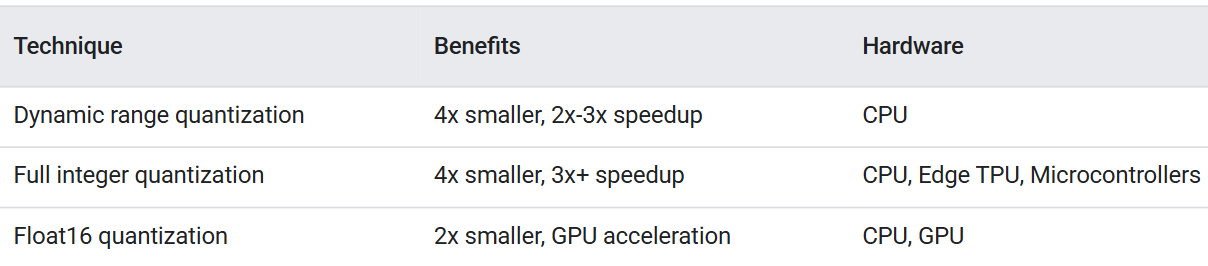

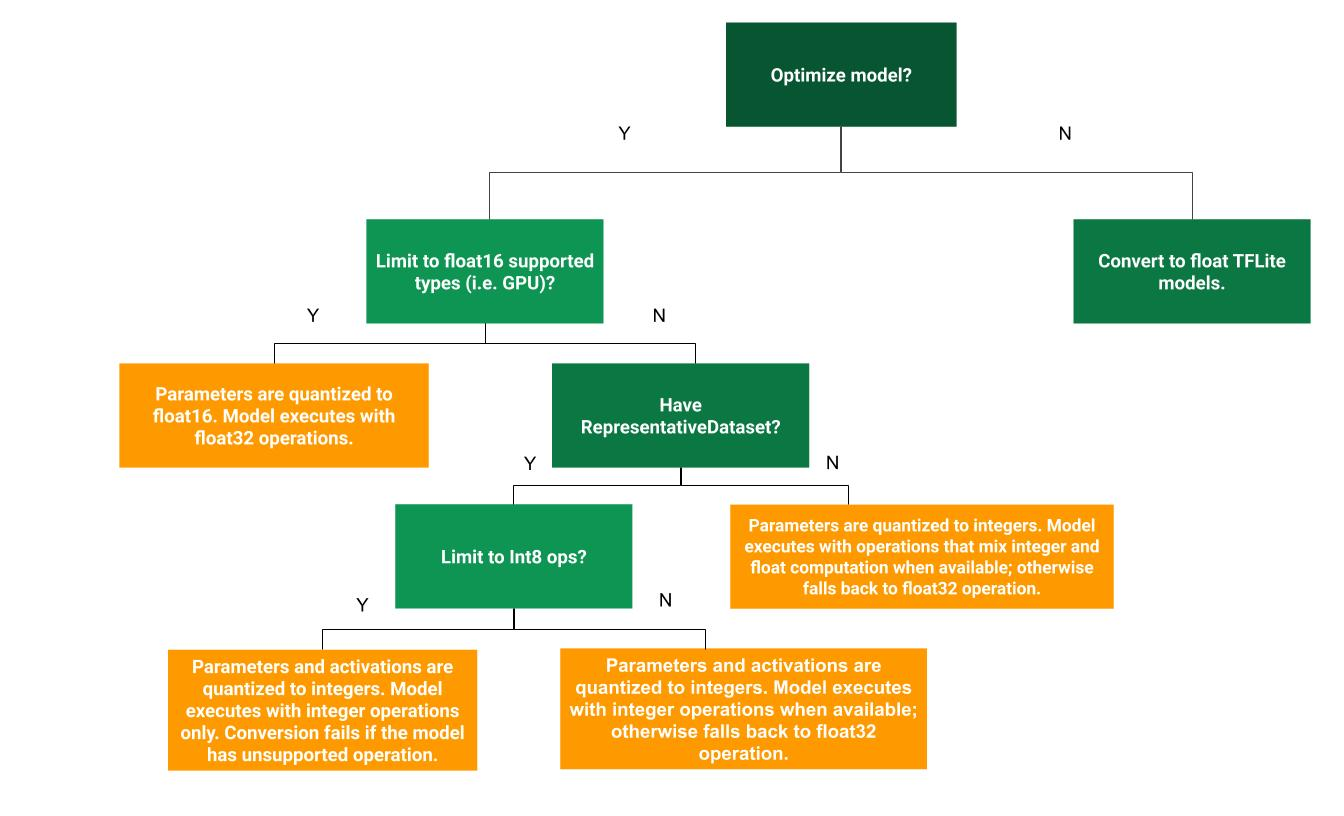

#### Dynamic Range Quantization

> "Statically quantizes only the weights from floating point to integer at conversion time, which provides 8-bits of precision"

In [ ]:
saved_model_dir = 'mobileNet_fashion.keras'

model = keras.models.load_model(saved_model_dir)

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

Saved artifact at '/tmp/tmpbigbcths'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  136418246327760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418246326224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418246325840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418246326032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418246326608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418246327568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418246323920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418246323536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418246323728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418246327952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418246322

In [ ]:
tflite_model_file = pathlib.Path('mobileNet_fashion_quant0.tflite')
tflite_model_file.write_bytes(tflite_quant_model)

315352

In [ ]:
acc_quant0, time_quant0 = evaluate_tflite_model('mobileNet_fashion_quant0.tflite', unbatched_dataset)

[[8.0960272e-06 1.0032922e-07 9.9954444e-01 2.1765911e-07 1.7101906e-06
  3.3319769e-15 4.4536666e-04 6.5810048e-12 1.8581567e-08 6.8754985e-10]]
<class 'numpy.float32'>
accuracy = 86.25%
Average time: 0.0018219089508056641


#### "Integer with float fallback"

In [ ]:
saved_model_dir = 'mobileNet_fashion.keras'

model = keras.models.load_model(saved_model_dir)

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_data_gen():
  for input_value, _ in unbatched_dataset.take(100):
    input_value =  (tf.expand_dims(input_value, axis=0)).numpy()
    yield [input_value]

converter.representative_dataset = representative_data_gen
# Target Model Datatypes
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

tflite_model = converter.convert()

Saved artifact at '/tmp/tmpuzjkin1t'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  136418558195088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418558188368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418558184528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418558194896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418558191440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418381695696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418381696080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418381696464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418381696272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418381694928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418381697

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(




> It won't be compatible with integer only devices (such as 8-bit microcontrollers) and accelerators (such as the Coral Edge TPU) because the input and output still remain float in order to have the same interface as the original float only model.



In [ ]:
# Save Model
tflite_model_file = pathlib.Path('mobileNet_fashion_quant.tflite')
tflite_model_file.write_bytes(tflite_model)

345656

In [ ]:
acc_quant1, time_quant1 = evaluate_tflite_model('mobileNet_fashion_quant.tflite', unbatched_dataset)

[[0.         0.         0.99609375 0.         0.         0.
  0.         0.         0.         0.        ]]
<class 'numpy.float32'>
accuracy = 83.75%
Average time: 0.0017923718690872191


#### Integer Only

In [ ]:
saved_model_dir = 'mobileNet_fashion.keras'
model = keras.models.load_model(saved_model_dir)
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.representative_dataset = representative_data_gen

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8

tflite_model_quant = converter.convert()

Saved artifact at '/tmp/tmpp_gugnt9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  136418277906512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418277907856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418277908240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418277908048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418277906704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418277906320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418277910160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418277910544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418277910352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418277907088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418277911

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
tflite_model_file = pathlib.Path('mobileNet_fashion_quant2.tflite')
tflite_model_file.write_bytes(tflite_model_quant)

345320

In [ ]:
acc_quant_2, time_quant2 = evaluate_tflite_model('mobileNet_fashion_quant2.tflite', unbatched_dataset)

[[-128 -128  127 -128 -128 -128 -128 -128 -128 -128]]
<class 'numpy.int8'>
accuracy = 83.25%
Average time: 0.003307706117630005


#### Float 16 Quantization

In [ ]:
saved_model_dir = 'mobileNet_fashion.keras'
model = keras.models.load_model(saved_model_dir)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_types = [tf.float16]

tflite_quant_model = converter.convert()

tflite_model_file = pathlib.Path('mobileNet_fashion_quant16.tflite')
tflite_model_file.write_bytes(tflite_quant_model)

Saved artifact at '/tmp/tmp63g_ojxp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  136418271537168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418271540240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418271541008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418271540048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418271539856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418271538128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418271536208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418271533328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418271536592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418271538320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136418271535

526476

In [ ]:
acc_quant_3, time_quant3 = evaluate_tflite_model('mobileNet_fashion_quant16.tflite', unbatched_dataset)

[[5.66945937e-06 3.35257994e-07 9.99495506e-01 1.45625700e-06
  2.86065970e-05 3.36200353e-14 4.68303537e-04 1.11035584e-10
  1.38263204e-07 2.95984925e-09]]
<class 'numpy.float32'>
accuracy = 87.5%
Average time: 0.0015266066789627075


#### Model Sizes

In [ ]:
size_quant1 = get_file_size('mobileNet_fashion_quant.tflite') # int 8 weights,
size_quant2 = get_file_size('mobileNet_fashion_quant2.tflite') # int 8 ops and i/o
size_quant3 = get_file_size('mobileNet_fashion_quant16.tflite') #Float 16 quant
size_quant0 = get_file_size('mobileNet_fashion_quant0.tflite') # Model with default quantization

### Model Comparison

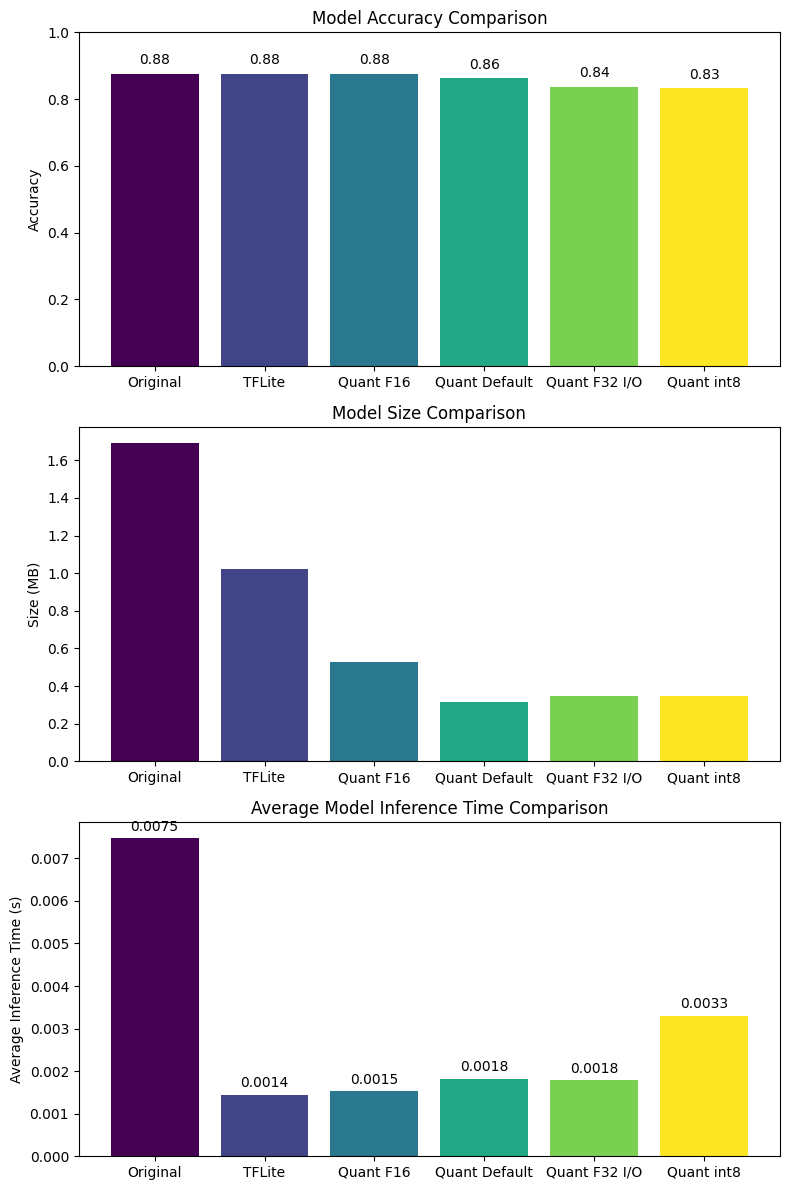

In [ ]:

model_names = ['Original', 'TFLite', 'Quant F16', 'Quant Default', 'Quant F32 I/O', 'Quant int8']
accuracies = [accuracy_original, acc_tflite, acc_quant_3, acc_quant0, acc_quant1, acc_quant_2,]

sizes = [size_original, size_tflite, size_quant3, size_quant0, size_quant1, size_quant2]

times = [time_original, time_tflite, time_quant3, time_quant0, time_quant1, time_quant2 ]


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))

colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))


bars1 = ax1.bar(model_names, accuracies, color=colors)
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy Comparison')
ax1.set_ylim([0, 1])

for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')



bars2 = ax2.bar(model_names, sizes, color=colors)
ax2.set_ylabel('Size (MB)')
ax2.set_title('Model Size Comparison')


bars3 = ax3.bar(model_names, times, color=colors)
ax3.set_ylabel('Average Inference Time (s)')
ax3.set_title('Average Model Inference Time Comparison')

for bar in bars3:
    yval = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, yval + 0.0001, f'{yval:.4f}', ha='center', va='bottom')


plt.tight_layout()
plt.show()

There were tested converted and compressed models:

1. ***TF without compressions***: This will convert a TF model and performs a series of optimizations and transformations, such as graph transformation where it identifies operations supported by TFLite and ajust the graph, it might remove redundant parts of the graph or will do some operation fusions. This model will do all the operations using float 32

2. ***Float 16 Quantization***: It will change the weights and biases in the model, however, inputs and outputs are FP32

3. ***Default Quantization***: It quantizes only the weights to integer precision by statistical processes. The outputs still are FP32

4. ***Integer With float fallback***: Dynamic range is calibrated according to a sample of data. Inputs and outputs are FP32.

5. ***Quantization int 8***: This will ensure that inputs and outputs are integers 8-bit format. This is suitable for constrained resource devices such as microcontrollers

